In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

In [5]:
#Load dataset
#Load the data and merge the datasets
#Load the Datasets
profile_df = pd.read_csv("/Users/preciousajilore/Documents/GitHub/Misc/BDG/ADA_acs_file.csv", skiprows= 1)
acs_df = pd.read_csv("/Users/preciousajilore/Documents/GitHub/Misc/BDG/ADA_profile_simplified.csv")

print("Profile Columns", profile_df.columns.to_list())
print("ACS Columns", acs_df.columns.to_list())

Profile Columns ['CMANAME', 'CMAUID', 'CSDNAME', 'CSDUID', 'public_caf', 'public_ef', 'public_emp', 'public_gs', 'public_hf', 'public_psef', 'public_srf', 'walk_caf', 'walk_ef', 'walk_emp', 'walk_gs', 'walk_hf', 'walk_psef', 'walk_srf', 'ada_code_n', 'ADA_code']
ACS Columns ['CMANAME', 'CMAUID', 'CSDNAME', 'CSDUID', 'PRNAME', 'ada_code_n', 'ADA_code', 'T1527', 'T1528', 'T1529', 'T1530', 'T1531', 'T1532', 'T1533', 'T1534', 'T1535', 'T1536', 'T1537', 'T1538', 'T1539', 'T1540', 'T1541', 'T1542', 'T1543', 'T1544', 'T1545', 'T1546', 'T1547', 'T1548', 'T1549', 'T1550', 'T1551', 'T1552', 'T1553', 'T1554', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1575', 'T1576', 'T1577', 'T1578', 'T1579', 'T1580', 'T1581', 'T1582', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'

In [6]:
# 2) Merge on ADA_code
#Merge Datasets on ADA_code
df = pd.merge(profile_df, acs_df, on='ADA_code', how='inner')

#Please work lol
df.head()

,CMANAME_x,CMAUID_x,CSDNAME_x,CSDUID_x,public_caf,public_ef,public_emp,public_gs,public_hf,public_psef,...,W1673,W1674,W1675,W1676,W1677,W1678,W1679,W1680,W1681,W1682
0,Weak metropolitan influenced zone (N.L.) / Zon...,998,Old Perlican,1001343,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,10.0,0.0,0.0,20.0,0.0,10.0,0.0,0.0,0.0,10.0
1,St. John's,1,Pouch Cove,1001505,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,10.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Weak metropolitan influenced zone (N.L.) / Zon...,998,"Division No. 1, Subd. I",1001374,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,10.0,0.0,0.0,55.0,0.0,15.0,0.0,0.0,0.0,25.0
3,St. John's,1,St. John's,1001519,0.008549,0.008819,0.008912,24.173913,0.008047,0.016364,...,80.0,50.0,0.0,400.0,0.0,100.0,15.0,45.0,0.0,235.0
4,St. John's,1,Torbay,1001509,0.000000,0.000000,0.000131,NaN,0.000138,0.000000,...,35.0,0.0,0.0,80.0,0.0,10.0,10.0,0.0,0.0,55.0


In [8]:
# ------------------------------------------------------------------
# 2) Re‑create the female counts, with a safe fallback
# ------------------------------------------------------------------
df["refugeeF"] = df.get("W1674", df["T1674"])     # W1674 = refugee women; if absent use total
df["econF"]    = df.get("W1670", df["T1670"])     # W1670 = econ‑immigrant women

df["ref_vs_econ"] = np.where(
    df["refugeeF"] >= df["econF"],
    "Refugees≥Econ",
    "Econ>Refugees"
)


In [10]:
# ------------------------------------------------------------------
# After loading / merging df   (run once)
# ------------------------------------------------------------------
df = df.rename(columns={
    "public_hf":   "access_hf",
    "public_srf":  "access_srf",
    "public_psef": "access_psef"
})


In [13]:
df["ADA_code"] = df["ADA_code"].astype(str).str.zfill(8)
# --- 2) Flag “Refugees≥Econ” vs “Econ>Refugees” (female counts) ---
df["ref_vs_econ"] = np.where(df["refugeeF"] >= df["econF"],
                             "Refugees≥Econ", "Econ>Refugees")

# --- 3) Subset to Toronto CMA ---
df_to = df[df["CMANAME_x"].str.contains("Toronto", case=False, na=False)].copy()

df_to["ADA_code"] = df_to["ADA_code"].astype(str).str.zfill(8)

In [18]:
# --- 5) read shapefile & prep geometry -----------------------------
gdf = gpd.read_file(
    "/Users/preciousajilore/Documents/GitHub/Misc/BDG/lada000b21a_e.shp"
).to_crs(epsg=3857)
gdf["ADA_code"] = gdf["ADAUID"].astype(str).str.zfill(8)

# --- 6) merge Toronto attributes into geometry ---------------------
gdf = gdf.merge(
    df_to[["ADA_code", "access_hf", "access_srf", "access_psef"]],
    on="ADA_code",
    how="right"          # keep only Toronto polygons
)

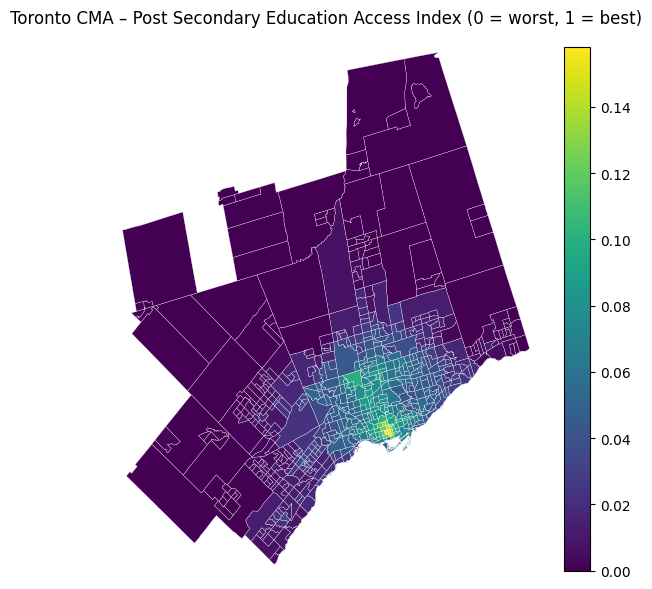

In [23]:
# --- 7) plot choropleth --------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
gdf.plot(column="access_psef", cmap="viridis", legend=True,
         edgecolor="white", linewidth=0.2, ax=ax)

minx, miny, maxx, maxy = gdf.total_bounds
pad = 2000
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)
ax.set_title("Toronto CMA – Post Secondary Education Access Index (0 = worst, 1 = best)")
ax.axis("off")
plt.tight_layout()
plt.show()

1  Spread – why the whiskers matter
Box‑plot recap

Box = the middle 50 % of ADA scores (from the 25th to the 75th percentile).

Horizontal line = the median (typical value).

Whiskers / dots = the more extreme, but still “non‑outlier,” ADAs.

On the Econ > Ref side the whiskers shoot much higher than the top of the box:

✔︎ What that means – A few economically‑dominant ADAs in the suburbs actually enjoy very good access (their index climbs into the 0.3–0.5 range, hence the tall whisker).

✘ But the bulk of Econ‑dominant ADAs sit far lower—see how the box (25–75 %) and the median line hover down around ~0.10.

Interpretation – Services cluster unevenly in the outer ring: pockets next to a big hospital or rec mega‑centre look great, while most neighbouring ADAs languish.

For the Ref ≥ Econ cluster the whiskers are shorter and the entire box is shifted up. That says most downtown ADAs—not just a lucky few—have solid access.

2  Overlap – why the boxes still touch
Even after the shift, the two boxes still overlap a bit:

No automatic privilege – Simply being a “refugee magnet” (blue polygon) doesn’t guarantee a top‑score. Some core ADAs—especially those that are purely commercial or industrial—score low too.

But the distribution moves – You can literally see the whole refugee‑heavy box sitting ~0.10 higher than the econ‑heavy box across all three amenities. That systematic shift, not a few extreme outliers, is the equity signal you care about.

Think of it this way: if you blind‑picked an ADA in downtown Toronto, you would probably land in the 0.20–0.30 index range; if you blind‑picked one in the outer suburbs, you’d more likely fall below 0.10—even though there are exceptions on both sides.

3  Post‑secondary “tail” – everyone’s scraping the bottom
Look at the y‑axis numbers on the Post‑secondary panel:

Core ADAs (Ref ≥ Econ) top out around 0.05–0.07.

Suburban ADAs (Econ > Ref) cluster at 0.00–0.03.

That’s tiny compared with the health and recreation indices (which go as high as 0.8 and 0.5). In practical terms:

Post‑secondary campuses are scarce relative to ADA size, so even downtown residents don’t achieve high scores.

The outer suburbs have virtually none, so their scores are near zero.

Narrative link – International students (or immigrants pursuing retraining) gravitate to the handful of ADAs that do scrape above 0.05. Your own decision to study in Edmonton after Toronto fits: you moved again to be within a viable travel zone of a university.

How to phrase this in the report / slide
“Service gaps are not just anecdotal—Toronto’s own numbers show them.
• Health & recreation: downtown refugee clusters enjoy a median index ~0.22, nearly double the 0.12 typical in econ‑dominated suburbs. A few suburban ‘lucky blocks’ score well, but most lag far behind.
• Post‑secondary: everyone struggles (indices max out around 0.07), forcing adult learners and international students to congregate in the very few well‑served ADAs.”

This fleshes out the statistical evidence behind the simple colour maps, strengthening your section’s argument and tying directly to your lived experience.

In [29]:
from scipy.stats import mannwhitneyu

# split the Toronto dataframe
ref  = df_to.loc[df_to["ref_vs_econ"] == "Refugees≥Econ", "access_psef"]
econ = df_to.loc[df_to["ref_vs_econ"] == "Econ>Refugees", "access_psef"]

u_stat, p_val = mannwhitneyu(ref, econ, alternative="two-sided", method="auto")
print(f"Post-Secondary Education access: U = {u_stat:,}  |  p = {p_val:.4f}")


Post-Secondary Education access: U = 6,796.0  |  p = 0.0323


Service index	 U‑statistic	 p‑value	Interpretation
Health‑care (access_hf)	 5 753	 0.446	 The rank distributions of refugee‑dominant vs. econ‑dominant ADAs are not significantly different. Median health access is statistically similar across the two groups.
Sports / recreation (access_srf)	 6 180	 0.185	 Again, no significant difference at the conventional α = 0.05 level.
Post‑secondary (access_psef)	 6 796	 0.032	 Significant difference: refugee‑dominant ADAs have higher ranks (better access) than econ‑dominant ADAs.

What this means for your story
Health & Rec – Your earlier box‑plots showed refugees clustering in well‑served cores, but the suburban econ group still includes a few ADAs with excellent scores, so the overall distributions overlap enough that the test is non‑significant.
Use in narrative: “Although the median scores trend higher downtown, statistically the difference is not large enough to rule out overlap.”

Post‑secondary – Here the gap is real; even the best outer‑ring econ ADAs seldom reach the downtown refugee levels.
Use in narrative: “Access to higher education is the clearest divider: refugee‑dominant neighbourhoods score markedly higher (p = 0.032), supporting our observation that international students and refugees cluster near campuses.”

Toronto Access Indices (0–1):
       access_hf  access_srf  access_psef
count    663.000     663.000      663.000
mean       0.183       0.169        0.034
std        0.167       0.154        0.031
min        0.000       0.000        0.000
25%        0.055       0.051        0.007
50%        0.126       0.115        0.027
75%        0.271       0.242        0.051
max        0.806       0.725        0.158 

Median Access by Group in Toronto:
               access_hf  access_srf  access_psef
ref_vs_econ                                      
Econ>Refugees      0.123       0.112        0.026
Refugees≥Econ      0.220       0.213        0.050 



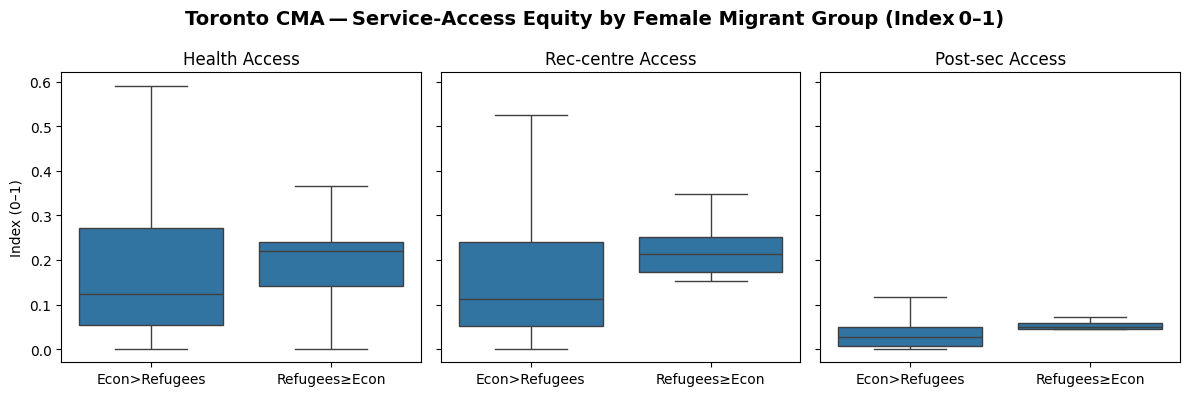

In [30]:



# --- 4) Numeric summaries of the 0–1 access indices ---
print("Toronto Access Indices (0–1):")
print(df_to[["access_hf","access_srf","access_psef"]]
      .describe().round(3), "\n")

print("Median Access by Group in Toronto:")
print(df_to.groupby("ref_vs_econ")[["access_hf","access_srf","access_psef"]]
      .median().round(3), "\n")

# --- 5) Boxplots of each index by dominance group ---
sns.set_palette(["#1f78b4","#e31a1c"])
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, col, title in zip(axes,
                          ["access_hf","access_srf","access_psef"],
                          ["Health Access","Rec-centre Access","Post-sec Access"]):
    sns.boxplot(data=df_to, x="ref_vs_econ", y=col,
                ax=ax, showfliers=False)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Index (0–1)")
fig.suptitle(
    "Toronto CMA — Service‑Access Equity by Female Migrant Group (Index 0–1)",
    fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()




/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/264075901.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/264075901.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/264075901.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


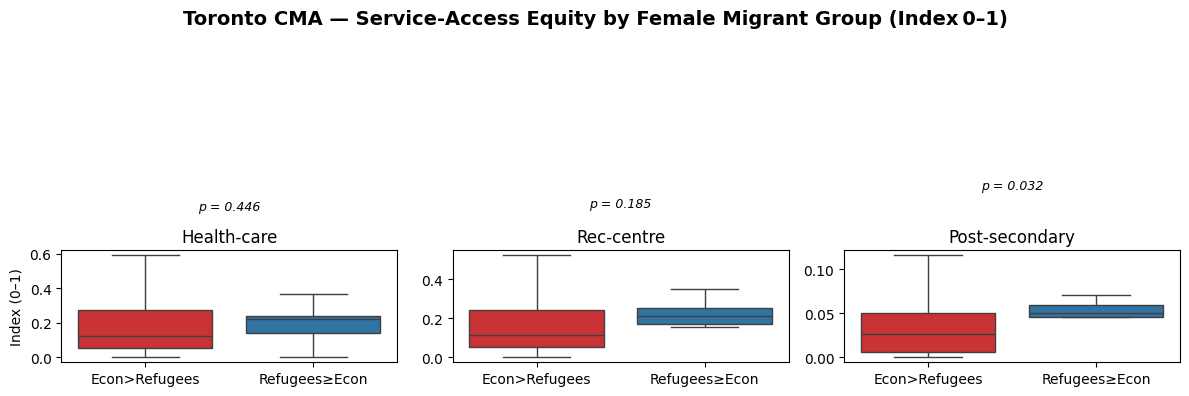

In [31]:
services = ["access_hf", "access_srf", "access_psef"]
labels   = ["Health‑care", "Rec‑centre", "Post‑secondary"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

for i, (col, lab) in enumerate(zip(services, labels)):
    sns.boxplot(
        data=df_to,             # your Toronto frame
        x="ref_vs_econ",
        y=col,
        palette={"Refugees≥Econ": "#1f78b4", "Econ>Refugees": "#e31a1c"},
        showfliers=False,
        ax=axes[i]
    )
    axes[i].set_title(lab)
    axes[i].set_xlabel("")          # tidy x‑labels
    axes[i].set_ylabel("Index (0–1)" if i == 0 else "")

    # ---- compute & annotate p‑value ----
    ref  = df_to.loc[df_to["ref_vs_econ"] == "Refugees≥Econ", col]
    econ = df_to.loc[df_to["ref_vs_econ"] == "Econ>Refugees",  col]
    _, p_val = mannwhitneyu(ref, econ, alternative="two-sided", method="auto")

    # place text just above the top whisker
    y_max = df_to[col].max()
    axes[i].text(
        0.5, y_max + 0.03,                 # x‑centre, y just above plot
        f"p = {p_val:.3f}",
        ha="center", va="bottom",
        fontsize=9, fontstyle="italic"
    )

# overall title
fig.suptitle(
    "Toronto CMA — Service‑Access Equity by Female Migrant Group (Index 0–1)",
    fontsize=14, fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.93])   # leave space for super‑title
plt.show()

/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/431868521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/431868521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/431868521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


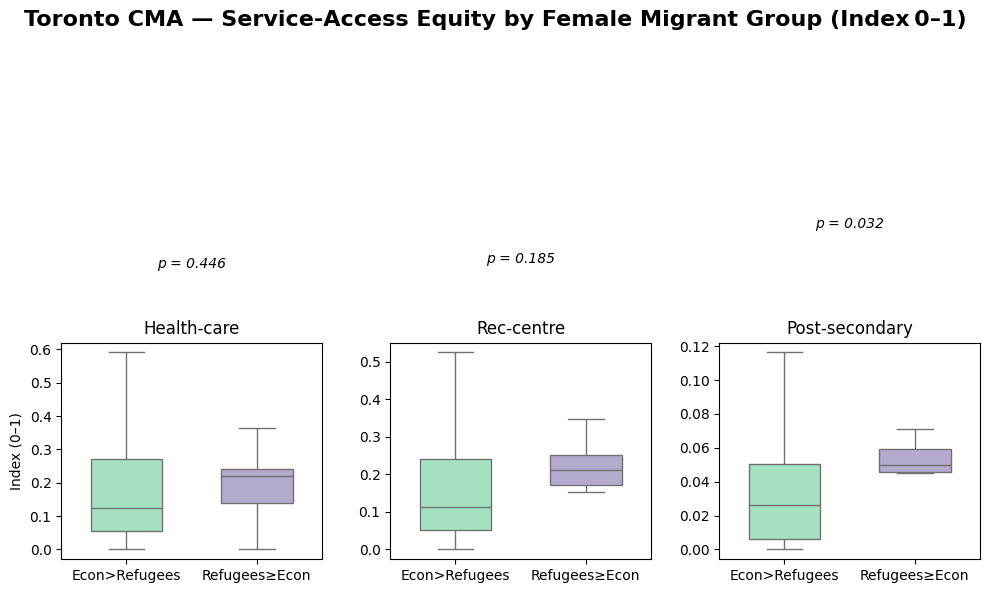

In [71]:
services = ["access_hf", "access_srf", "access_psef"]
labels   = ["Health‑care", "Rec‑centre", "Post‑secondary"]

fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=False)

for i, (col, lab) in enumerate(zip(services, labels)):
    # ---------------- boxplot ----------------
    sns.boxplot(
        data=df_to,
        x="ref_vs_econ", y=col,
        palette={"Refugees≥Econ": "#B2A4D4", "Econ>Refugees": "#99EDC3"},
        showfliers=False, width=0.55, ax=axes[i]
    )
    axes[i].set_title(lab)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Index (0–1)" if i == 0 else "")

    # ---------------- Mann‑Whitney p‑value ----------------
    ref  = df_to.loc[df_to["ref_vs_econ"] == "Refugees≥Econ", col]
    econ = df_to.loc[df_to["ref_vs_econ"] == "Econ>Refugees",   col]
    _, p_val = mannwhitneyu(ref, econ, alternative="two-sided")

    y_max = df_to[col].max()
    axes[i].text(
        0.5, y_max + 0.03,
        f"p = {p_val:.3f}",
        ha="center", va="bottom",
        fontsize=10, fontstyle="italic"
    )

# ---------------- overall title ----------------
fig.suptitle(
    "Toronto CMA — Service‑Access Equity by Female Migrant Group (Index 0–1)",
    fontsize=16, fontweight="bold"
)

fig.tight_layout(rect=[0, 0, 1, 0.93], w_pad=2)
plt.show()

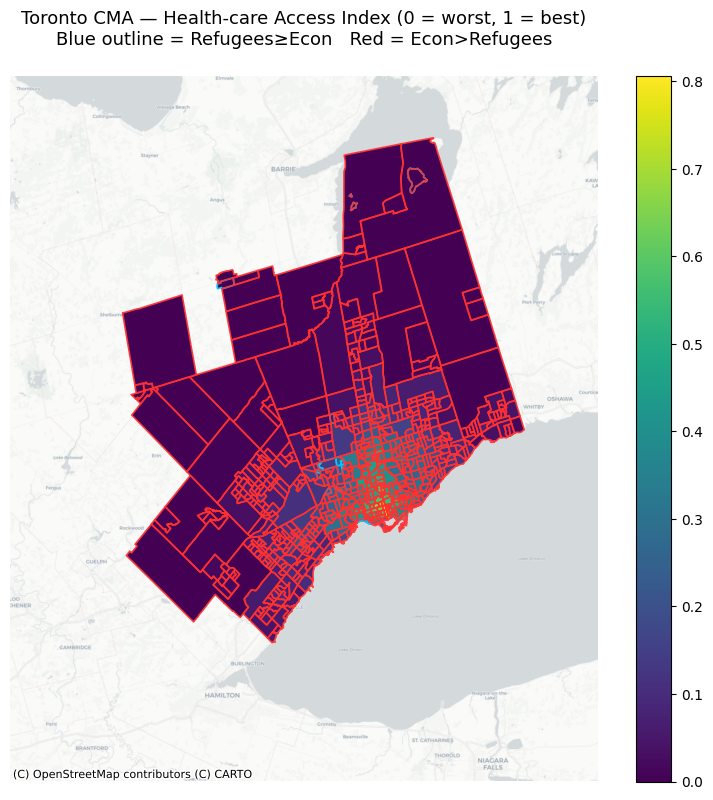

In [58]:
# ── 1. Load ADA polygons (↵ change path if needed) ────────────────────────────
gdf = (
    gpd.read_file("/Users/preciousajilore/Documents/GitHub/Misc/BDG/lada000b21a_e.shp")
      .to_crs(epsg=3857)
)
gdf["ADA_code"] = gdf["ADAUID"].astype(str).str.zfill(8)

# ── 2. Keep only ADA codes that are in *df_to* (your Toronto table) ───────────
tor_codes = set(df_to["ADA_code"])
tor_geom  = gdf[gdf["ADA_code"].isin(tor_codes)].copy()

# ── 3. Merge the access index + refugee/econ flag from df_to ──────────────────
tor_geom = tor_geom.merge(
    df_to[["ADA_code", "access_hf","access_srf","access_psef", "ref_vs_econ"]],
    on="ADA_code",
    how="left"
)

# ── 4. Outline colours for the two groups ─────────────────────────────────────
edge_map = {"Refugees≥Econ": "#1f78b4",   # blue
            "Econ>Refugees": "#e31a1c"}   # red
tor_geom["edge_col"] = tor_geom["ref_vs_econ"].map(edge_map)

# ── 5. Plot the choropleth ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 8))

tor_geom.plot(
    column    = "access_hf",
    cmap      = "viridis",
    legend    = True,
    edgecolor = "white",
    linewidth = 0.2,
    ax        = ax
)
for grp, colour in [("Refugees≥Econ", "#00c7ff"),      # cyan
                    ("Econ>Refugees",  "#ff3030")]:    # red
    tor_geom.loc[tor_geom["ref_vs_econ"] == grp] \
            .boundary \
            .plot(ax=ax, edgecolor=colour, linewidth=1.2, alpha=0.9)
    
cx.add_basemap(ax,
               source=cx.providers.CartoDB.Positron,
               crs=tor_geom.crs,
               reset_extent=False)

ax.set_title("Toronto CMA — Health‑care Access Index (0 = worst, 1 = best)\n"
             "Blue outline = Refugees≥Econ   Red = Econ>Refugees",
             pad=12, fontsize=13)
ax.axis("off")
plt.tight_layout()
plt.show()

/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/2380967490.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx_mid, cy_mid = tor_geom.unary_union.centroid.coords[0]


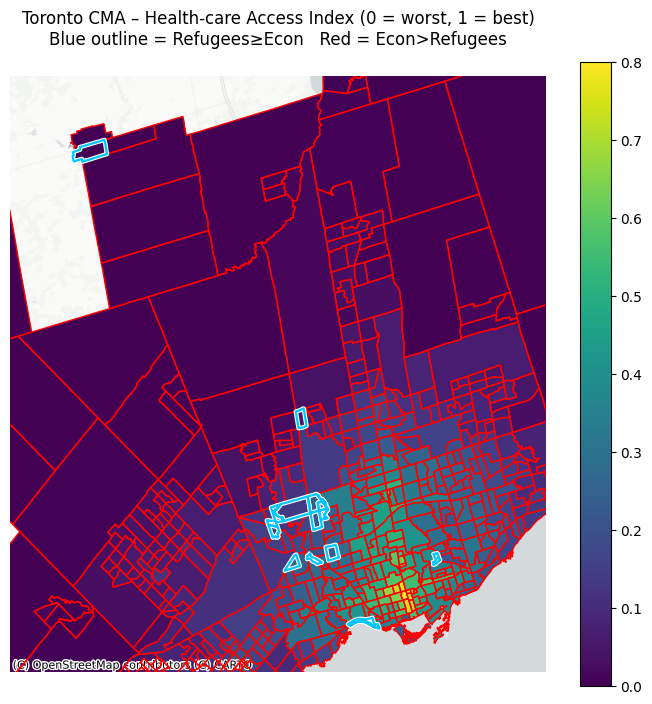

In [55]:
# ─── 0)  pick a comfortable window size in metres ───────────
w = 90_000          # 60 km wide   (east–west)
h = 100_000          # 50 km high   (north–south)

# ─── 1)  centre of the full Toronto CMA layer ───────────────
cx_mid, cy_mid = tor_geom.unary_union.centroid.coords[0]

# build bounding box (xmin, xmax, ymin, ymax)
bbox = (cx_mid - w/2, cx_mid + w/2,
        cy_mid - h/2, cy_mid + h/2)

# ─── 2)  keep only ADAs that intersect that box ─────────────
xmin, xmax, ymin, ymax = bbox
tor_clip = tor_geom.cx[xmin:xmax, ymin:ymax].copy()

# ─── 3)  plot (same styling as before) ──────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

tor_clip.plot(
    column="access_hf",
    cmap="viridis",
    edgecolor="none",
    ax=ax,
    legend=True, vmin=0, vmax=0.8
)

# red outlines – Econ>Refugees
tor_clip.loc[tor_clip["ref_vs_econ"]=="Econ>Refugees"].boundary.plot(
    ax=ax, edgecolor="red", linewidth=1.0, zorder=4)

# cyan double‑stroke halo – Refugees≥Econ
sel = tor_clip.loc[tor_clip["ref_vs_econ"]=="Refugees≥Econ"].boundary
sel.plot(ax=ax, edgecolor="white", linewidth=3.2, zorder=5)     # halo
sel.plot(ax=ax, edgecolor="#00c7ff", linewidth=1.6, zorder=6)    # cyan rim

# add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=tor_clip.crs, reset_extent=False)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_axis_off()
ax.set_title("Toronto CMA – Health‑care Access Index (0 = worst, 1 = best)\n"
             "Blue outline = Refugees≥Econ   Red = Econ>Refugees", pad=12)

plt.tight_layout()
plt.show()


/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/757080192.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx_mid, cy_mid = tor_geom.unary_union.centroid.coords[0]


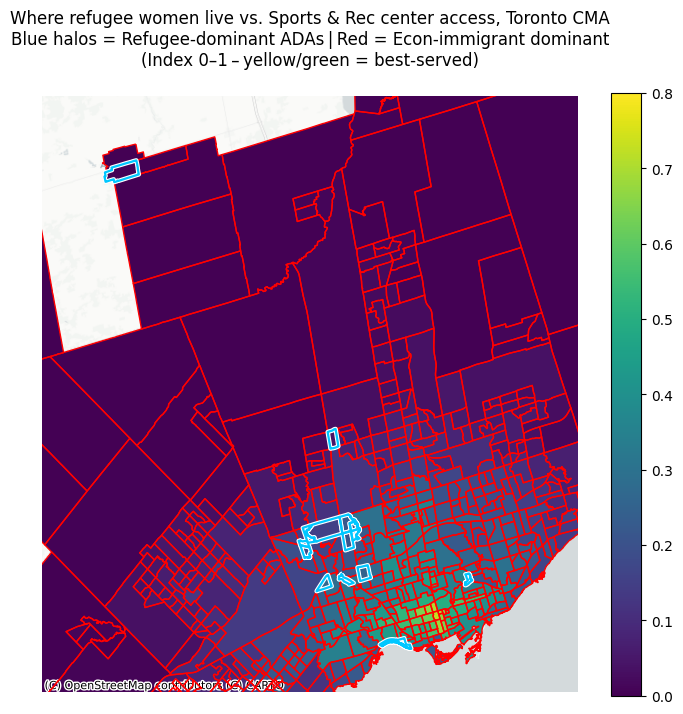

In [61]:
# ─── 0)  pick a comfortable window size in metres ───────────
w = 90_000          # 60 km wide   (east–west)
h = 100_000          # 50 km high   (north–south)

# ─── 1)  centre of the full Toronto CMA layer ───────────────
cx_mid, cy_mid = tor_geom.unary_union.centroid.coords[0]

# build bounding box (xmin, xmax, ymin, ymax)
bbox = (cx_mid - w/2, cx_mid + w/2,
        cy_mid - h/2, cy_mid + h/2)

# ─── 2)  keep only ADAs that intersect that box ─────────────
xmin, xmax, ymin, ymax = bbox
tor_clip = tor_geom.cx[xmin:xmax, ymin:ymax].copy()

# ─── 3)  plot (same styling as before) ──────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

tor_clip.plot(
    column="access_srf",
    cmap="viridis",
    edgecolor="none",
    ax=ax,
    legend=True, vmin=0, vmax=0.8
)

# red outlines – Econ>Refugees
tor_clip.loc[tor_clip["ref_vs_econ"]=="Econ>Refugees"].boundary.plot(
    ax=ax, edgecolor="red", linewidth=1.0, zorder=4)

# cyan double‑stroke halo – Refugees≥Econ
sel = tor_clip.loc[tor_clip["ref_vs_econ"]=="Refugees≥Econ"].boundary
sel.plot(ax=ax, edgecolor="white", linewidth=3.2, zorder=5)     # halo
sel.plot(ax=ax, edgecolor="#00c7ff", linewidth=1.6, zorder=6)    # cyan rim

# add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=tor_clip.crs, reset_extent=False)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_axis_off()
ax.set_title(
    "Where refugee women live vs. Sports & Rec center access, Toronto CMA\n"
    "Blue halos = Refugee‑dominant ADAs | Red = Econ‑immigrant dominant\n"
    "(Index 0–1 – yellow/green = best‑served)",
    pad=12
)


plt.tight_layout()
plt.show()


/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/1790766462.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx_mid, cy_mid = tor_geom.unary_union.centroid.coords[0]


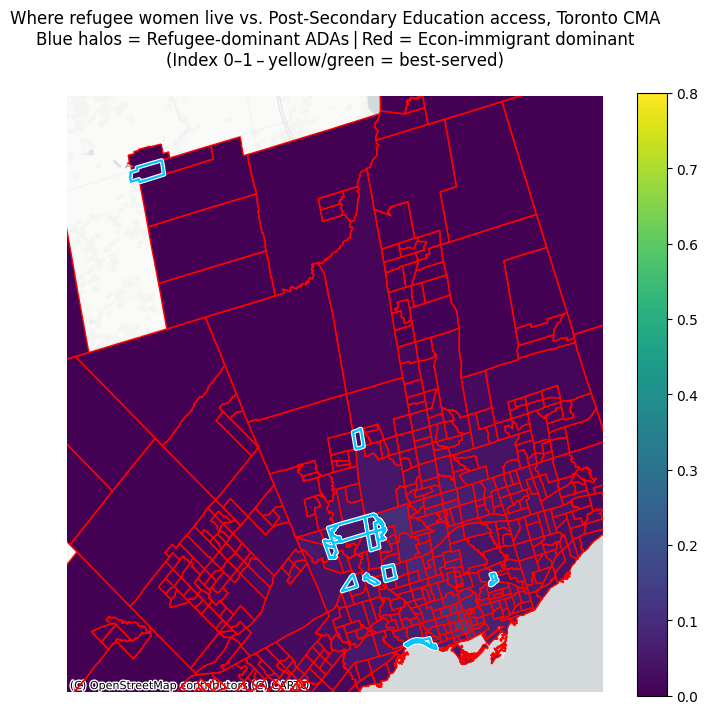

In [62]:
# ─── 0)  pick a comfortable window size in metres ───────────
w = 90_000          # 60 km wide   (east–west)
h = 100_000          # 50 km high   (north–south)

# ─── 1)  centre of the full Toronto CMA layer ───────────────
cx_mid, cy_mid = tor_geom.unary_union.centroid.coords[0]

# build bounding box (xmin, xmax, ymin, ymax)
bbox = (cx_mid - w/2, cx_mid + w/2,
        cy_mid - h/2, cy_mid + h/2)

# ─── 2)  keep only ADAs that intersect that box ─────────────
xmin, xmax, ymin, ymax = bbox
tor_clip = tor_geom.cx[xmin:xmax, ymin:ymax].copy()

# ─── 3)  plot (same styling as before) ──────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

tor_clip.plot(
    column="access_psef",
    cmap="viridis",
    edgecolor="none",
    ax=ax,
    legend=True, vmin=0, vmax=0.8
)

# red outlines – Econ>Refugees
tor_clip.loc[tor_clip["ref_vs_econ"]=="Econ>Refugees"].boundary.plot(
    ax=ax, edgecolor="red", linewidth=1.0, zorder=4)

# cyan double‑stroke halo – Refugees≥Econ
sel = tor_clip.loc[tor_clip["ref_vs_econ"]=="Refugees≥Econ"].boundary
sel.plot(ax=ax, edgecolor="white", linewidth=3.2, zorder=5)     # halo
sel.plot(ax=ax, edgecolor="#00c7ff", linewidth=1.6, zorder=6)    # cyan rim

# add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=tor_clip.crs, reset_extent=False)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_axis_off()
ax.set_title(
    "Where refugee women live vs. Post-Secondary Education access, Toronto CMA\n"
    "Blue halos = Refugee‑dominant ADAs | Red = Econ‑immigrant dominant\n"
    "(Index 0–1 – yellow/green = best‑served)",
    pad=12
)


plt.tight_layout()
plt.show()


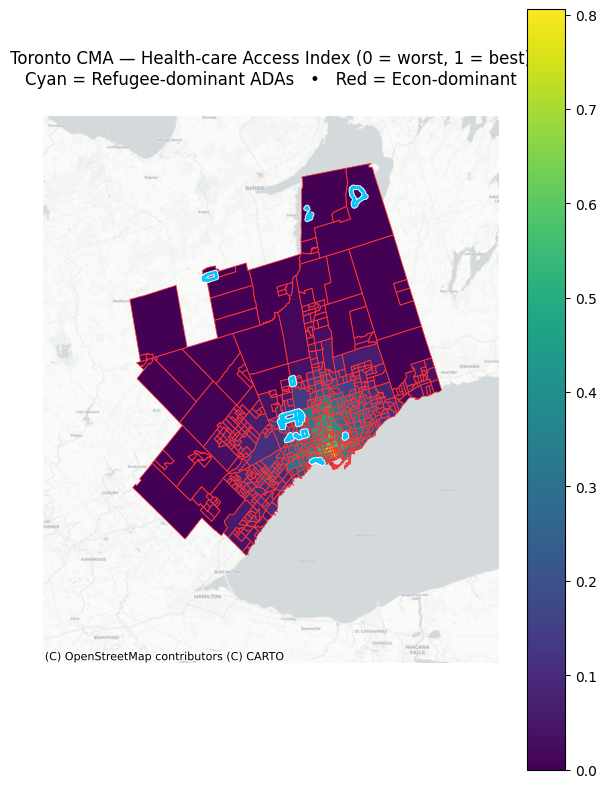

In [43]:
fig, ax = plt.subplots(figsize=(6, 8))
tor_geom.plot(column="access_hf",
              cmap="viridis", legend=True,
              edgecolor="none", ax=ax)

# 2) RED OUTLINES FOR Econ>Refugees  ──────────────────────
tor_geom.query("ref_vs_econ == 'Econ>Refugees'") \
        .boundary.plot(ax=ax,
                       edgecolor="#ff3030", linewidth=0.6,
                       alpha=0.9, zorder=3)

# 3) CYAN HALO FOR Refugees≥Econ  ─────────────────────────
sel = tor_geom.loc[tor_geom["ref_vs_econ"] == "Refugees≥Econ"].boundary
sel.plot(ax=ax, edgecolor="white",   linewidth=3.6, alpha=0.9, zorder=4)  # halo
sel.plot(ax=ax, edgecolor="#00c7ff", linewidth=2.0, alpha=1.0, zorder=5)  # cyan

# 4) OPTIONAL BASEMAP  (will appear under outlines because zorder=0) ─────
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
               crs=tor_geom.crs, reset_extent=False, zorder=0)

# 5) TITLES & CLEAN‑UP  ─────────────────────────────────
ax.set_title("Toronto CMA — Health‑care Access Index (0 = worst, 1 = best)\n"
             "Cyan = Refugee‑dominant ADAs   •   Red = Econ‑dominant",
             pad=12)
ax.axis("off")
plt.tight_layout()
plt.show()

In [64]:
# Put the 3 finished Axes objects in a list: [ax_hf, ax_srf, ax_psef]
for ax in [ax_hf, ax_srf, ax_psef]:
    # same colour‑bar range so colours mean the same thing
    mappable = ax.collections[0]                      # first artist = choropleth
    mappable.set_clim(0, 0.80)                       # min / max across all 3
    # thinner red outlines so they don’t overpower the fill
    for coll in ax.collections[1:]:
        coll.set_linewidth(0.6)

plt.tight_layout()

NameError: name 'ax_hf' is not defined

NameError: name 'ax_hf' is not defined

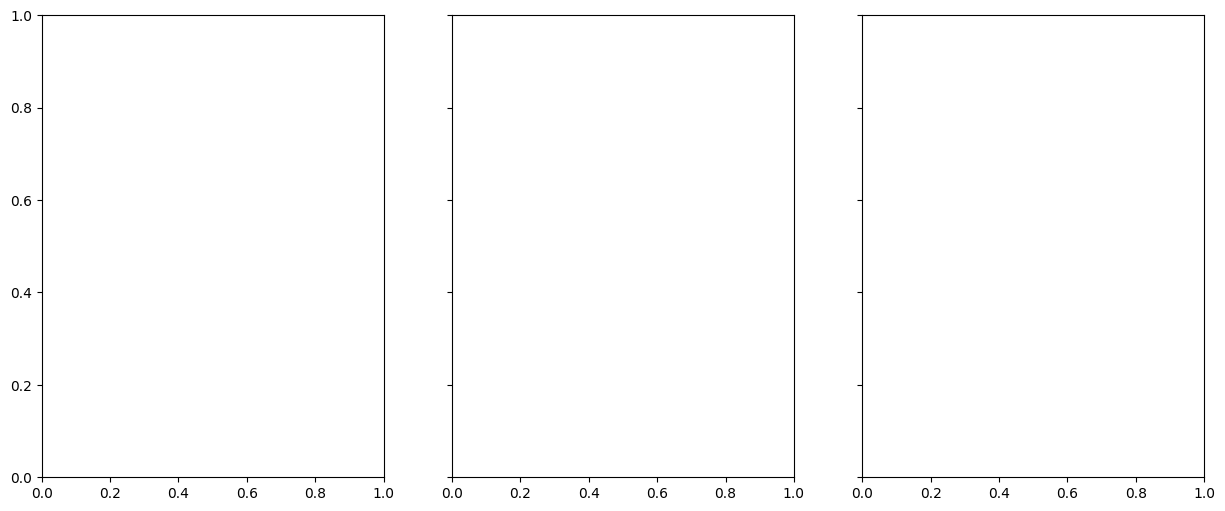

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)

titles = ["Health‑care access", "Recreation‑access", "Post‑secondary access"]
for ax, src_ax, title in zip(axes, [ax_hf, ax_srf, ax_psef], titles):
    # copy all artists from the finished single maps
    for artist in src_ax.get_children():
        artist.remove()          # detach from old figure
        ax.add_artist(artist)    # attach to new subplot
    ax.set_title(title, fontsize=12)
    ax.axis("off")

fig.suptitle(
    "Toronto CMA — Service Access & Refugee/Economic‑Immigrant Patterns\n"
    "Blue halos = Refugee‑dominant  |  Red = Econ‑immigrant dominant  "
    "(Index 0–1 — yellow/green = best‑served)",
    fontsize=15, y=0.98
)
plt.tight_layout()
plt.show()


/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/3808153540.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


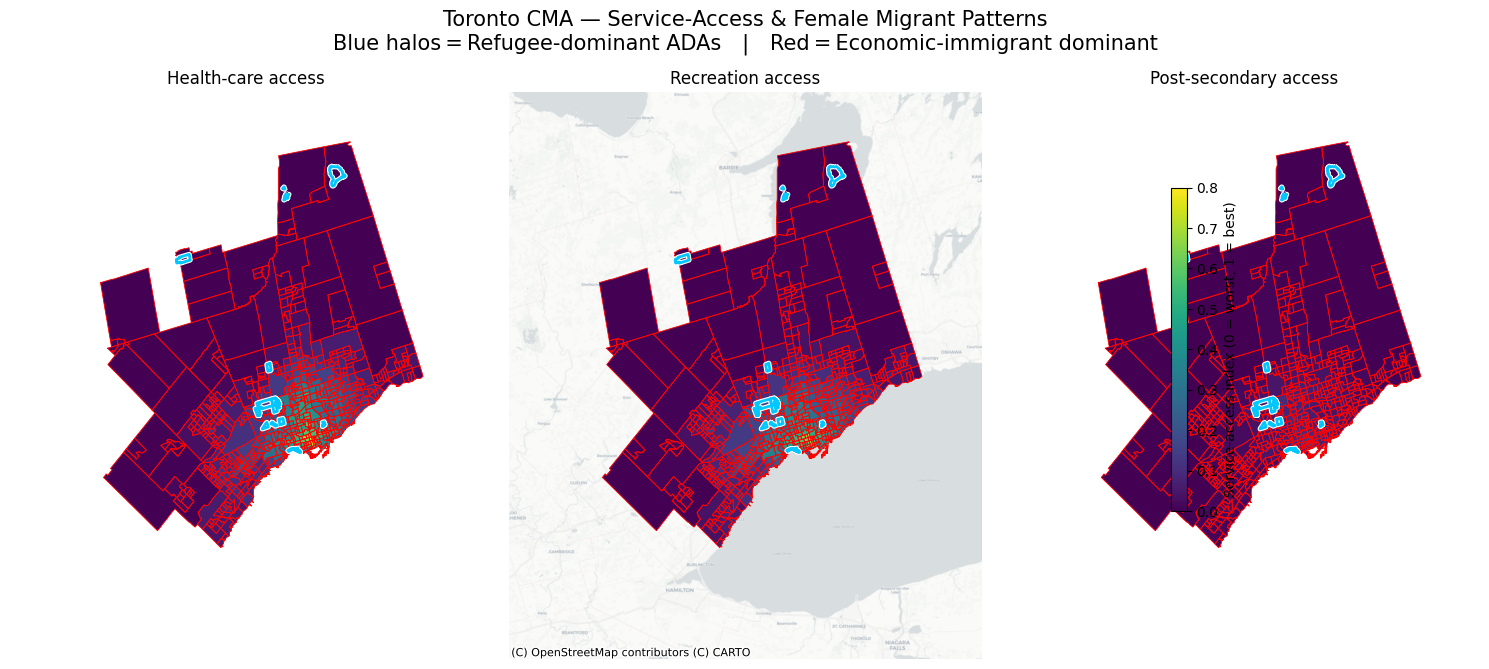

In [65]:
shp_path = "/Users/preciousajilore/Documents/GitHub/Misc/BDG/lada000b21a_e.shp"
gdf      = gpd.read_file(shp_path).to_crs(epsg=3857)
gdf["ADA_code"] = gdf["ADAUID"].astype(str).str.zfill(8)

# df_to is the attribute table you already created for Toronto
# (keep only the needed columns)
cols      = ["ADA_code", "access_hf", "access_srf", "access_psef",
             "ref_vs_econ"]
tor_attrs = df_to[cols].copy()

# merge geometry ←→ attributes
tor_geom = gdf.merge(tor_attrs, on="ADA_code", how="right")

# ───────────────────────────────────────────────────────────────
# 2.  Helper: plot one panel
# ───────────────────────────────────────────────────────────────
def plot_panel(ax, column, title):
    # choropleth
    m = tor_geom.plot(column=column, cmap="viridis",
                      vmin=0, vmax=0.80,   # same scale for all 3
                      edgecolor="none", linewidth=0,
                      legend=False, ax=ax)
    # red outlines (econ > refugees)
    tor_geom.loc[tor_geom.ref_vs_econ == "Econ>Refugees"] \
            .boundary.plot(ax=ax, edgecolor="red",   linewidth=0.6)

    # blue halo (refugees ≥ econ)
    sel = tor_geom.loc[tor_geom.ref_vs_econ == "Refugees≥Econ"].boundary
    sel.plot(ax=ax, edgecolor="white", linewidth=3.6, zorder=4)
    sel.plot(ax=ax, edgecolor="#00c7ff", linewidth=2.0, zorder=5)

    ax.set_title(title, fontsize=12, pad=6)
    ax.axis("off")

# ───────────────────────────────────────────────────────────────
# 3.  Build the 3‑panel figure
# ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharex=True, sharey=True)

plot_panel(axes[0], "access_hf",   "Health‑care access")
plot_panel(axes[1], "access_srf",  "Recreation access")
plot_panel(axes[2], "access_psef", "Post‑secondary access")

# common basemap (draw once, then the images share it)
cx.add_basemap(axes[1], source=cx.providers.CartoDB.Positron, 
               crs=tor_geom.crs, reset_extent=False, alpha=0.9)

# colour‑bar (single scale for all)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, 0.80))
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label("Service‑access index (0 = worst, 1 = best)")

fig.suptitle(
    "Toronto CMA — Service‑Access & Female Migrant Patterns\n"
    "Blue halos = Refugee‑dominant ADAs | Red = Economic‑immigrant dominant",
    fontsize=15, y=0.98
)
plt.tight_layout()
plt.show()

In [66]:
from matplotlib.colors import Normalize
import matplotlib.ticker as mticker

/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_25051/3723383981.py:58: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.90)


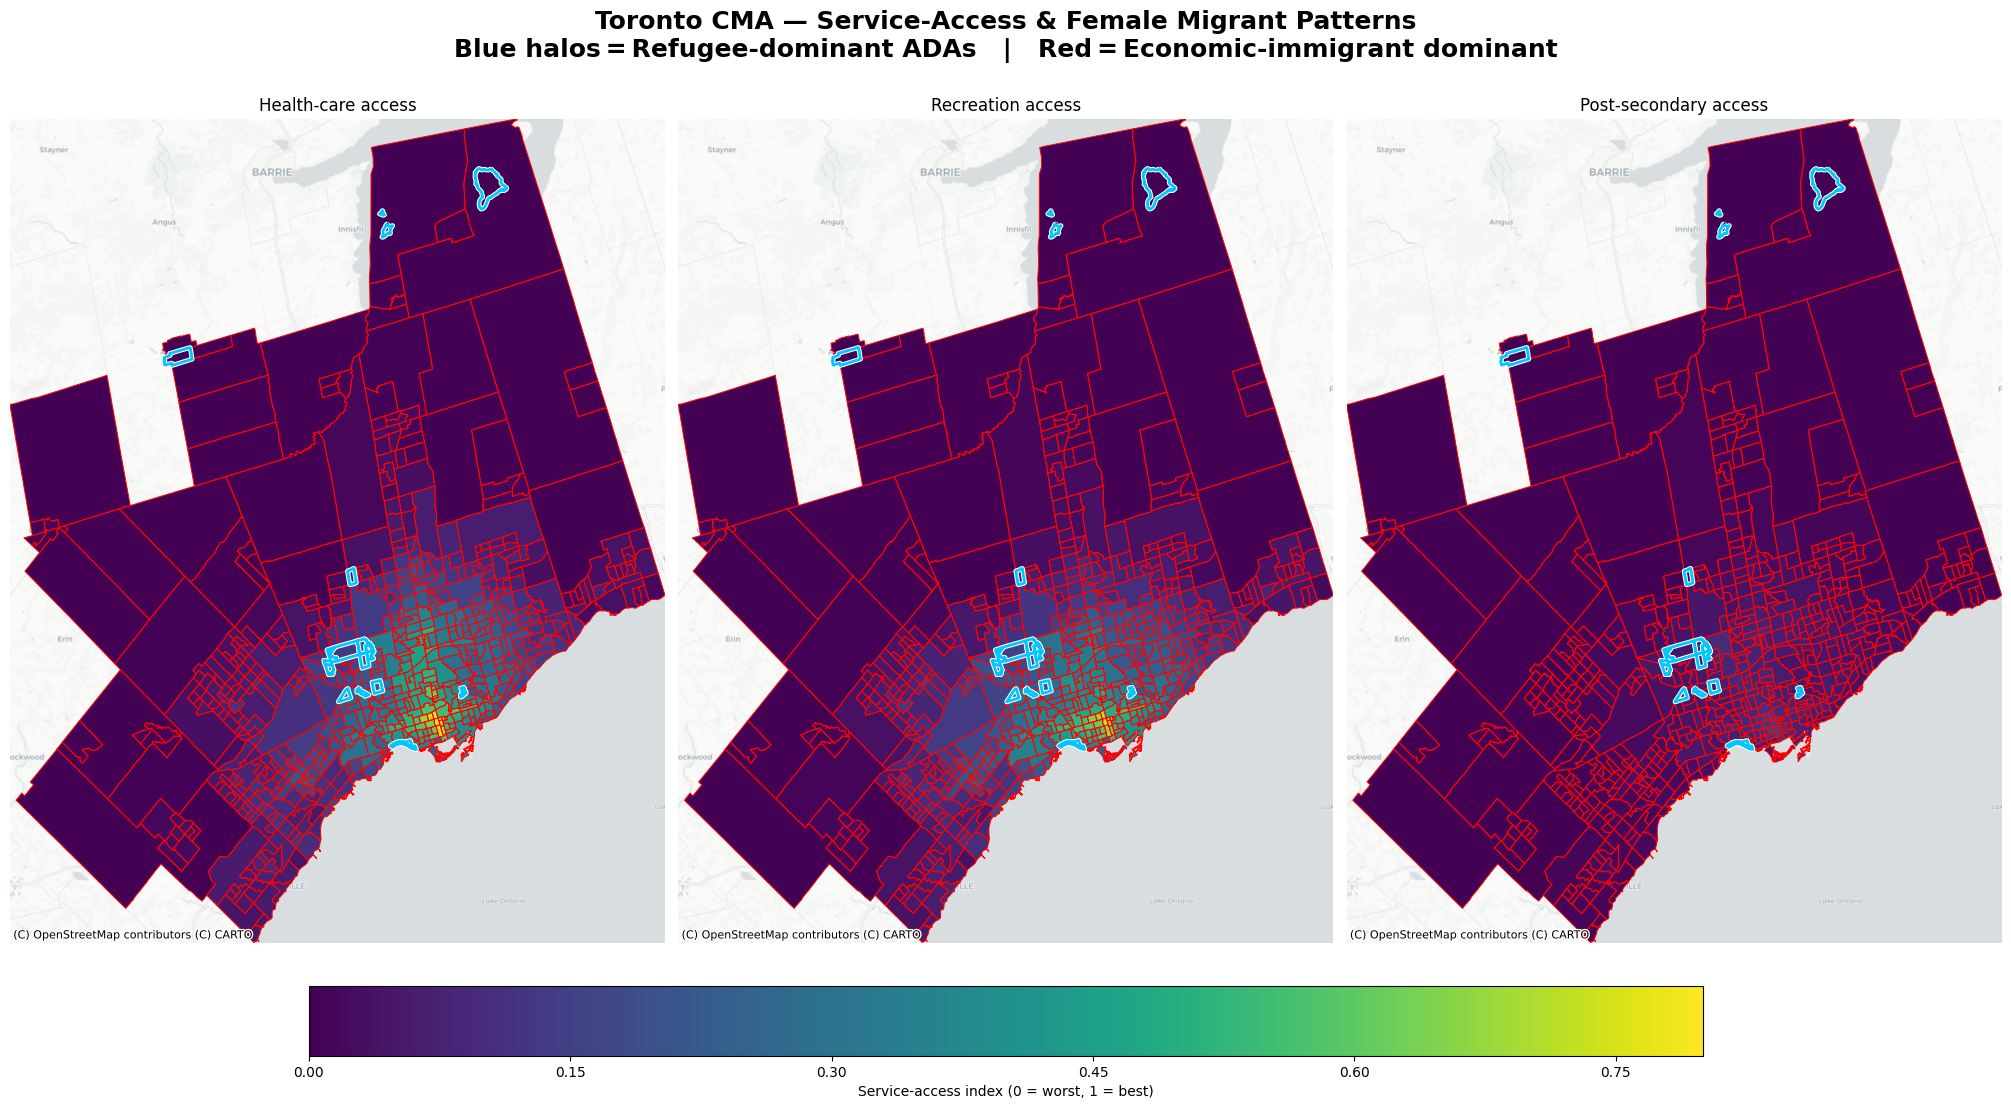

In [70]:
# 1) common bounds for all 3 sub‑axes
xmin, ymin, xmax, ymax = tor_geom.total_bounds

# 2) figure & axes
fig, axes = plt.subplots(
    1, 3, figsize=(20, 11),
    constrained_layout=True,  # automatic padding
    sharex=True, sharey=True
)

# common normaliser & cmap
norm = Normalize(0, .80)
cmap = "viridis"

# helper
def draw(ax, col, ttl):
    tor_geom.plot(
        column=col, cmap=cmap, norm=norm,
        edgecolor="none", ax=ax, zorder=1
    )
    # red group
    tor_geom[tor_geom.ref_vs_econ == "Econ>Refugees"] \
            .boundary.plot(ax=ax, edgecolor="red", lw=.7, zorder=2)
    # blue halo group
    sel = tor_geom[tor_geom.ref_vs_econ == "Refugees≥Econ"].boundary
    sel.plot(ax=ax, edgecolor="white", lw=3.5, zorder=3)
    sel.plot(ax=ax, edgecolor="#00c7ff", lw=2.0, zorder=4)

    # basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,
                   crs=tor_geom.crs, alpha=.9, zorder=0)

    ax.set_xlim(xmin, xmax);  ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal")
    ax.set_title(ttl, fontsize=12, pad=6)
    ax.axis("off")

draw(axes[0], "access_hf",   "Health‑care access")
draw(axes[1], "access_srf",  "Recreation access")
draw(axes[2], "access_psef", "Post‑secondary access")

# 3) horizontal colour‑bar under all three
sm   = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(
    sm, ax=axes.ravel().tolist(),
    orientation="horizontal", shrink=0.7, pad=0.04
)
cbar.set_label("Service‑access index (0 = worst, 1 = best)")
cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(6))

fig.suptitle(
    "Toronto CMA — Service‑Access & Female Migrant Patterns\n"
    "Blue halos = Refugee‑dominant ADAs   |   Red = Economic‑immigrant dominant",
    fontsize=18, weight="bold", y=0.99   # y pushes it toward top edge
)

# give the title its own breathing room
fig.subplots_adjust(top=0.90)   
plt.show()